## Figures for pleiotropy/genetic correlation experiment
This notebook generates figures based on results from our pleiotropy/genetic correlation experiment (Figure 3 of our associated pub: [Epistasis and deep learning in quantitative genetics](https://doi.org/10.57844/arcadia-25nt-guw3)). The figures visualizes how well deep learning can predict phenotypes (relative to linear models) when multiple phenotypes are genetically correlated. 

### Input Data
This notebook takes as input the results generated from our scaling experiment. These can be generated by running the Snakemake files found in the directory of this notebook```workflow_sims/alphasimr_pleio```.

Specifically, the notebook collects phenotype prediction statistics (validation set Pearson's r) from text files generated by ```../common_scripts/fit_ridge_cv.py```, ```fit_mlp.py```, and ```fit_feat_seln.py```. The prediction statistics are written to text files in directories ```linear_model/``` , and ```gpnet/```. This represents output from ridge regression, and a simple MLP. These files will contain simulation run parameters in their names e.g. ```gpnet/qhaplo_16qtl_1000n_rep1_phenotype_correlations.csv```(ie., 16 QTLs, 1000 samples, replicate 1) which this notebook will extract and use when plotting results. 

Note, to generate these model outputs first you must generate simulated data by running the entire Snakemake pipeline. See repo README for more details. 

### Notebook workflow
- Harvest model performance outputs for all models
- Combine into one file for plotting
- Plot MLP model performance against the ridge regression baseline (Figure 3)

### Harvest model output files and combine into one dataframe

In [12]:
import pandas as pd
import glob
import re
import os
import matplotlib.pyplot as plt
import arcadia_pycolor as apc
import numpy as np

In [13]:
apc.mpl.setup()

In [14]:
def harvest_mod_outputs(path, file_pattern, output_filename=None):
    """
    Processes files in a directory matching a pattern, extracts parameters from filenames,
    and creates subplots comparing linear vs neural correlations by QTL parameter.

    Args:
        path: String path to the directory containing files
        file_pattern: String pattern for glob to match files (e.g., 'qhaplo_*qtl_*marker_*n_rep*_*.csv')
        output_filename: Optional filename for saving the plot (default: 'correlation_comparison.png')

    Returns:
        DataFrame: Combined dataframe of all processed files
        Figure: Matplotlib figure object for further customization if needed
    """
    # Get all files that match the pattern
    csv_files = glob.glob(os.path.join(path, file_pattern))

    if not csv_files:
        print(f"No files found matching pattern '{file_pattern}' in '{path}'")
        return None, None

    # Create an empty list to store individual dataframes
    dfs = []

    # Process each file
    for file in csv_files:
        # Extract the filename from the path
        filename = os.path.basename(file)

        # Extract parameters using regex
        qtl_match = re.search(r'(\d+)qtl', filename)
        n_match = re.search(r'(\d+)n', filename)
        rep_match = re.search(r'rep(\d+)', filename)
        trait_match = re.search(r'(\d+)trait', filename)
        pleio_match = re.search(r'(\d+)pleio', filename)

        if qtl_match and n_match and rep_match:
            qtl_value = int(qtl_match.group(1))
            n_value = int(n_match.group(1))
            rep_value = int(rep_match.group(1))
            trait_value = int(trait_match.group(1))
            pleio_value = int(pleio_match.group(1))


                # Read the CSV file
            df = pd.read_csv(file)

            # Add columns for the parameters
            df['qtl_param'] = qtl_value
            df['n_param'] = n_value
            df['rep'] = rep_value
            df['n_trait'] = trait_value
            df['pleio'] = pleio_value


            # Add the dataframe to our list
            dfs.append(df)
        else:
            print(f"Couldn't extract parameters from {filename}")

    # Combine all dataframes into one
    if dfs:
        outdf = pd.concat(dfs, ignore_index=True)

        # Display the first few rows of the combined dataframe
        print(outdf.head())

    else:
        print("No matching files found or parameters couldn't be extracted")
    return outdf

In [15]:
linear_df = harvest_mod_outputs('./gplinear', 'qhaplo_*qtl_*n_*pleio_*trait_rep*_phenotype_correlations_untuned.csv')
neural_df = harvest_mod_outputs('./gpnet', 'qhaplo_*qtl_*n_*pleio_*trait_rep*_phenotype_correlations.csv')
linear_sklr = harvest_mod_outputs('./linear_model', 'qhaplo_*qtl_*n_*pleio_*trait_rep*_scklrr_corr_summary.txt')


   trait_number  pearson_correlation  p_value  true_mean  pred_mean  true_std  \
0             1             0.487265      0.0  -0.012515   0.029491  0.997945   
1             2             0.477062      0.0  -0.007013   0.028730  1.000042   
2             3             0.503262      0.0  -0.029288   0.063768  0.990669   
3             4             0.507306      0.0  -0.011081   0.004294  1.004711   
4             5             0.467553      0.0  -0.021740   0.007519  0.995503   

   pred_std trait_architecture  qtl_param  n_param  rep  n_trait  pleio  
0  0.201772                1-5       1000    10000    2       10     25  
1  0.205202                1-5       1000    10000    2       10     25  
2  0.208638                1-5       1000    10000    2       10     25  
3  0.205687                1-5       1000    10000    2       10     25  
4  0.211568                1-5       1000    10000    2       10     25  
   trait_number  pearson_correlation  true_mean  pred_mean  true_std 

In [16]:
linear_sklr.rename(columns={'pearson_corr_pheno_mean':'pearson_correlation'}, inplace=True)
linear_sklr.rename(columns={'trait':'trait_number'}, inplace=True)

In [17]:
def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait', 'rep']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait', 'rep']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait', 'rep'])

    return common_params

# Get common parameter combinations
common_params = get_parameter_combinations(linear_sklr, neural_df)

In [18]:
comparison_data = []

for _, row in common_params.iterrows():
    qtl = row['qtl_param']
    n = row['n_param']
    trait = row['trait_number']
    pleio = row['pleio']
    n_trait = row['n_trait']
    rep = row['rep']

    linear_row = linear_sklr[(linear_sklr['qtl_param'] == qtl) &
                           (linear_sklr['n_param'] == n) &
                           (linear_sklr['trait_number'] == trait) &
                           (linear_sklr['pleio'] == pleio) &
                           (linear_sklr['n_trait'] == n_trait)&
                           (linear_sklr['rep'] == rep)]

    neural_row = neural_df[(neural_df['qtl_param'] == qtl) &
                           (neural_df['n_param'] == n) &
                           (neural_df['trait_number'] == trait) &
                           (neural_df['pleio'] == pleio) &
                           (neural_df['n_trait'] == n_trait) &
                           (neural_df['rep'] == rep)]

    if not linear_row.empty and not neural_row.empty:
        comparison_data.append({
            'qtl_param': qtl,
            'n_param': n,
            'trait_number': trait,
            'rep': rep,
            'pleio': pleio,
            'n_trait': n_trait,
            'linear_correlation': linear_row['pearson_correlation'].values[0],
            'neural_correlation': neural_row['pearson_correlation'].values[0],
            'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
        })

df = pd.DataFrame(comparison_data)

In [19]:
df['pleio'] = df['pleio']/100 #adjust to match simulation param

### Figure 3. 
Plots the difference in validation Pearson's r for a naive MLP vs a ridge regression baseline. 
Simulations are based on sets of either 10 or 100 correlated phenotypes, with varying degrees of genetic correlation/pleiotropy in their QTL effect sizes, ranging from 0 (indpendent traits) to 0.95 (almost perfect correlation). 

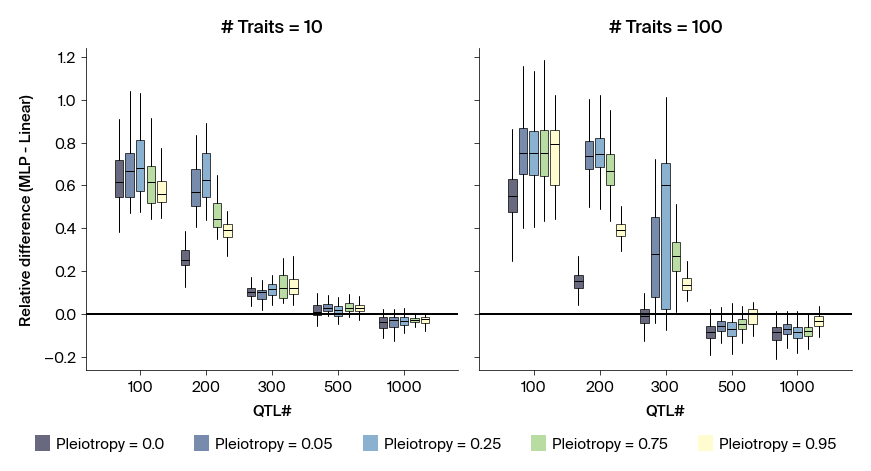

In [20]:
# Assuming df is your already properly formatted DataFrame

# Get unique values
qtl_param_values = sorted(df['qtl_param'].unique())
pleio_values = sorted(df['pleio'].unique())
unique_n_traits = sorted(df['n_trait'].unique())

# Create a figure with subplots in one row (one subplot per n_trait)
fig, axes = plt.subplots(1, len(unique_n_traits), figsize=(6*len(unique_n_traits), 6),
                         sharey=True)

# Create color map for pleiotropy levels
#pleio_colors = plt.cm.viridis(np.linspace(0, 1, len(pleio_values)))
#pleio_color_map = dict(zip(pleio_values, pleio_colors))


cmap = apc.gradients.viridis.to_mpl_cmap()
pleio_colors = cmap(np.linspace(0, 1, len(pleio_values)))
pleio_color_map = dict(zip(pleio_values, pleio_colors))

# Create each subplot (one per n_trait)
for i, n_trait in enumerate(unique_n_traits):
    # Get the correct axis for this subplot
    if len(unique_n_traits) == 1:
        ax = axes
    else:
        ax = axes[i]

    # Filter data for this n_trait
    n_trait_data = df[df['n_trait'] == n_trait]

    # For each qtl_param value
    for j, qtl_param in enumerate(qtl_param_values):
        # Filter data for this qtl_param
        qtl_data = n_trait_data[n_trait_data['qtl_param'] == qtl_param]

        if not qtl_data.empty:
            # Set the x-position for this group of boxplots
            x_pos = j + 1  # Base position (1, 2, 3, etc.)

            # Prepare data for side-by-side boxplots
            boxplot_data = []
            positions = []
            colors = []

            # Group by pleiotropy level
            for k, pleio_val in enumerate(pleio_values):
                # Filter data for this pleiotropy level
                pleio_data = qtl_data[qtl_data['pleio'] == pleio_val]

                if not pleio_data.empty:
                    values = pleio_data['difference'].values
                    if len(values) > 0:
                        boxplot_data.append(values)

                        # Calculate offset for side-by-side positioning
                        width = 0.8 / len(pleio_values)
                        offset = (k - (len(pleio_values)-1)/2) * width
                        positions.append(x_pos + offset)

                        colors.append(pleio_color_map[pleio_val])

            # Create boxplots for this qtl_param
            if boxplot_data:
                bplot = ax.boxplot(boxplot_data, positions=positions,
                                  patch_artist=True, widths=0.8/len(pleio_values)*0.8,
                                  showfliers=False, showcaps=False,
                                  medianprops={'color': 'black'},
                                  boxprops={'color': 'black'})

                # Color boxplots based on pleiotropy level
                for patch, color in zip(bplot['boxes'], colors):
                    patch.set(facecolor=color, alpha=0.7)

    # Set titles and labels
    ax.set_title(f'# Traits = {n_trait}')
    ax.set_xlabel('QTL#')
    if i == 0:  # Only add y-label to the first subplot
        ax.set_ylabel('Relative difference (MLP - Linear)')

    # Set x-tick positions and labels
    ax.set_xticks(range(1, len(qtl_param_values) + 1))
    ax.set_xticklabels(qtl_param_values)
    ax.axhline(y=0, color='black')


# Add a legend for pleiotropy levels
handles = []
labels = []
for pleio_val in pleio_values:
    patch = plt.Rectangle((0, 0), 1, 1, color=pleio_color_map[pleio_val], alpha=0.7)
    handles.append(patch)
    labels.append(f'Pleiotropy = {pleio_val}')

# Add the legend
fig.legend(handles, labels,
           loc='upper center', bbox_to_anchor=(0.5, 0),
           ncol=min(5, len(pleio_values)))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the legend at the bottom
plt.savefig("Figure_3.svg", bbox_inches='tight')
# Show the plot
plt.show()
